In [1]:
import sys
sys.path.append("../../src/earthtext")

import rasterio
import xarray as xr
import os
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from osm import osm
from osm import multilabel
from collections import OrderedDict
import pandas as pd
from progressbar import progressbar as pbar
from joblib import Parallel, delayed
from pyproj import CRS
import numpy as np
epsg4326 = CRS.from_epsg(4326)

get_region_hash = osm.get_region_hash

In [2]:
imgs_folder    = "/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips"
osmobjs_folder = "/opt/data/california-worldcover-chips/osm"
master_index   = "/opt/data/california-worldcover-chips.fgb"

In [3]:
from importlib import reload
reload(multilabel)
iosdata = multilabel.ImageOSMData(imgs_folder=imgs_folder, osmobjs_folder=osmobjs_folder, master_index=master_index).init_index()

In [4]:
OSMMergedKeyValueCodes = multilabel.OSMMergedKeyValueCodes
kvopen   = multilabel.kvopen
kvclosed = multilabel.kvclosed
kvmerged = OSMMergedKeyValueCodes(kvclosed, kvopen)
max_code = np.max(list(kvmerged.keyvals_codes.values()))


In [5]:
reload(multilabel)
chip_id = iosdata.m.index[np.random.randint(len(iosdata.m))]
c = multilabel.ImageOSMChip(iosdata, chip_id).read_osm()

In [6]:
keyval_onehot,keyval_strs = c.get_onehot()

In [7]:
keyval_strs

['highway=*', 'highway=track', 'waterway=*', 'waterway=stream']

In [8]:
keyval_onehot.T[keyval_onehot.T['count']>0].T

,13,14,93,98
area,0.000000,0.000000,0.000000,0.000000
length,3325.760617,3325.760617,8.270575,8.270575
count,3.000000,3.000000,1.000000,1.000000


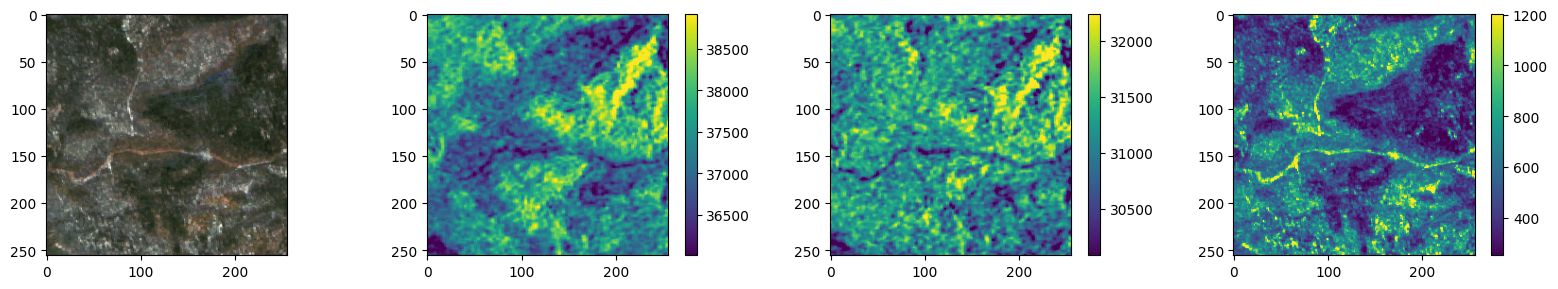

In [9]:
c.read_img().show()

In [10]:
k = gpd.read_parquet("/opt/data/california-worldcover-chips-osm-multilabels.parquet")
k.head()

,onehot_label,string_labels,col,row,geometry,split
chip_id,,,,,,
2d020602331e4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track]",122624,111104,"POLYGON ((-114.76000 32.72000, -114.76000 32.7...",train
34c5edf7ed602,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[amenity, amenity=parking, highway, highway=tr...",122624,110848,"POLYGON ((-114.76000 32.74133, -114.76000 32.7...",train
370214ce19e1d,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track, highway=motorway, hig...",122368,110848,"POLYGON ((-114.78133 32.74133, -114.78133 32.7...",train
371eeed5e3259,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track, highway=motorway, hig...",122112,110848,"POLYGON ((-114.80267 32.74133, -114.80267 32.7...",train
24763185559b0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track]",122112,110592,"POLYGON ((-114.80267 32.76267, -114.80267 32.7...",train


## create the multilabels

In [44]:
while True:
    splits = np.linspace(0, len(iosdata.m), 20).astype(int)
    splits[-1]+=1
    splits = [[splits[i], splits[i+1]] for i in range(len(splits)-1)]
    splits = np.random.permutation(splits)
    if splits[0][0] == 17671:
        break
splits

array([[ 17671,  23562],
       [ 64795,  70686],
       [ 94248, 100138],
       [100138, 106029],
       [ 53014,  58905],
       [ 35343,  41233],
       [ 88357,  94248],
       [ 47124,  53014],
       [ 29452,  35343],
       [  5890,  11781],
       [ 41233,  47124],
       [ 11781,  17671],
       [ 23562,  29452],
       [ 76576,  82467],
       [     0,   5890],
       [ 58905,  64795],
       [ 82467,  88357],
       [106029, 111921],
       [ 70686,  76576]])

In [39]:
# 17671 : 23562
reload(osm)
reload(multilabel)

<module 'osm.multilabel' from '/home/ubuntu/earth-text/notebooks/data/../../src/earthtext/osm/multilabel.py'>

In [40]:
from rlxutils import ElapsedTimes
et = ElapsedTimes()

In [47]:
ImageOSMChip = multilabel.ImageOSMChip
r = []

for start,end in splits:
    print (f"\n{start} : {end}", flush=True)
    for chip_id in pbar(iosdata.m.index[start:end]):
        try:
            with et("load"):
                keyval_onehot,keyval_strs = ImageOSMChip(iosdata, chip_id).read_osm().get_onehot()
            with et("extract"):
                onehot_area = keyval_onehot.loc['area'].values.copy()
                onehot_count = keyval_onehot.loc['count'].values.copy()
                onehot_length = keyval_onehot.loc['length'].values.copy()
                keyval_strs = [i for i in keyval_strs]
            with et("append"):
                r.append([chip_id, onehot_count, onehot_area, onehot_length, keyval_strs])
        except:
            continue
            



64795 : 70686


100% (5891 of 5891) |####################| Elapsed Time: 0:03:46 Time:  0:03:460118



94248 : 100138


100% (5890 of 5890) |####################| Elapsed Time: 0:06:31 Time:  0:06:310332



100138 : 106029


100% (5891 of 5891) |####################| Elapsed Time: 0:04:18 Time:  0:04:180221



53014 : 58905


100% (5891 of 5891) |####################| Elapsed Time: 0:03:32 Time:  0:03:320117



35343 : 41233


100% (5890 of 5890) |####################| Elapsed Time: 0:01:38 Time:  0:01:380007



88357 : 94248


100% (5891 of 5891) |####################| Elapsed Time: 0:03:43 Time:  0:03:430118



47124 : 53014


100% (5890 of 5890) |####################| Elapsed Time: 0:00:50 Time:  0:00:500002



29452 : 35343


100% (5891 of 5891) |####################| Elapsed Time: 0:03:35 Time:  0:03:350118



5890 : 11781


100% (5891 of 5891) |####################| Elapsed Time: 0:03:23 Time:  0:03:230116



41233 : 47124


100% (5891 of 5891) |####################| Elapsed Time: 0:01:45 Time:  0:01:450218



11781 : 17671


100% (5890 of 5890) |####################| Elapsed Time: 0:04:54 Time:  0:04:540219



23562 : 29452


100% (5890 of 5890) |####################| Elapsed Time: 0:04:25 Time:  0:04:250222



76576 : 82467


100% (5891 of 5891) |####################| Elapsed Time: 0:04:02 Time:  0:04:020219



0 : 5890


100% (5890 of 5890) |####################| Elapsed Time: 0:01:04 Time:  0:01:040004



58905 : 64795


100% (5890 of 5890) |####################| Elapsed Time: 0:05:27 Time:  0:05:270225



82467 : 88357


100% (5890 of 5890) |####################| Elapsed Time: 0:03:56 Time:  0:03:560219



106029 : 111921


100% (5891 of 5891) |####################| Elapsed Time: 0:03:45 Time:  0:03:450219



70686 : 76576


100% (5890 of 5890) |####################| Elapsed Time: 0:03:44 Time:  0:03:440118


In [48]:
et

{'load': 4351.248381614685, 'extract': 37.36514091491699, 'append': 0.09970879554748535}

## create dataframe with multilabels

In [49]:
len(r)

83609

In [68]:
rr = pd.DataFrame(r, columns=['chip_id', 'onehot_count', 'onehot_area', 'onehot_length', 'string_labels'])
rr.set_index('chip_id', inplace=True)
rr['onehot_count'] = [i.astype(np.int32) for i in rr.onehot_count.values]

In [69]:
rr.head()

,onehot_count,onehot_area,onehot_length,string_labels
chip_id,,,,
193c3415fc237,"[24, 24, 1344, 388, 472, 21, 453, 2, 8, 0, 0, ...","[58033.967200952815, 58033.967200952815, 23937...","[4913.205774298301, 4913.205774298301, 74943.4...","[amenity=*, amenity=parking, building=*, build..."
1639b12583426,"[148, 148, 4171, 1245, 1891, 52, 938, 13, 32, ...","[160073.78667008967, 160073.78667008967, 80191...","[20966.344659970102, 20966.344659970102, 24881...","[amenity=*, amenity=parking, building=*, build..."
253904d963d6a,"[65, 65, 200, 104, 76, 0, 18, 2, 0, 0, 0, 0, 0...","[101980.95118259436, 101980.95118259436, 71246...","[10597.989172272657, 10597.989172272657, 16664...","[amenity=*, amenity=parking, building=*, build..."
00530dca88d4a,"[9, 9, 4897, 688, 4026, 0, 172, 10, 1, 0, 0, 0...","[17637.908172952746, 17637.908172952746, 10930...","[1925.4953839123748, 1925.4953839123748, 32065...","[amenity=*, amenity=parking, building=*, build..."
0e554bbdbe661,"[80, 80, 4358, 1262, 2386, 59, 597, 27, 27, 0,...","[131950.60085068244, 131950.60085068244, 98472...","[13536.03447682216, 13536.03447682216, 283601....","[amenity=*, amenity=parking, building=*, build..."


In [78]:
rv = pd.DataFrame(np.r_[[list(i>0) for i in rr.onehot_count.values]])

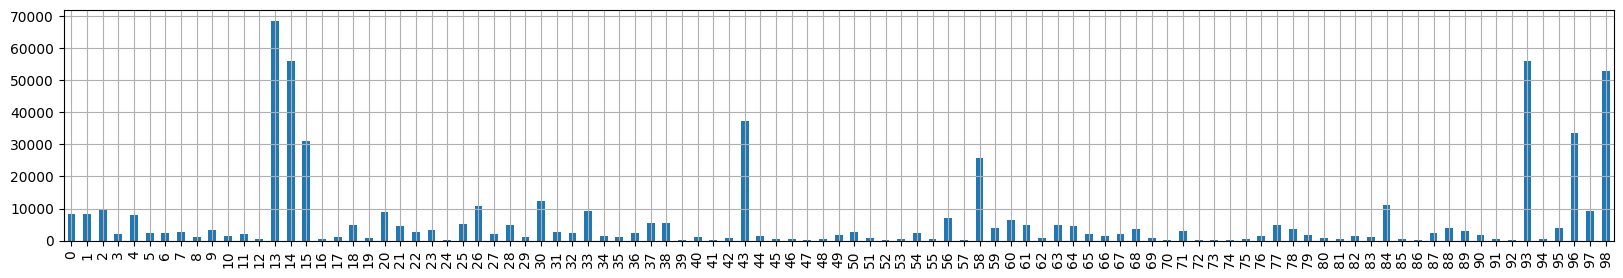

In [84]:
rv.sum(axis=0).plot(kind='bar', figsize=(20,3))
plt.grid();

## join with original metadata dataframe

In [85]:
rohem = gpd.GeoDataFrame(rr.join(iosdata.m), crs=epsg4326)
rohem


,onehot_count,onehot_area,onehot_length,string_labels,col,row,geometry
chip_id,,,,,,,
193c3415fc237,"[24, 24, 1344, 388, 472, 21, 453, 2, 8, 0, 0, ...","[58033.967200952815, 58033.967200952815, 23937...","[4913.205774298301, 4913.205774298301, 74943.4...","[amenity=*, amenity=parking, building=*, build...",78080,96000,"POLYGON ((-118.47200 33.97867, -118.47200 34.0..."
1639b12583426,"[148, 148, 4171, 1245, 1891, 52, 938, 13, 32, ...","[160073.78667008967, 160073.78667008967, 80191...","[20966.344659970102, 20966.344659970102, 24881...","[amenity=*, amenity=parking, building=*, build...",78080,95744,"POLYGON ((-118.47200 34.00000, -118.47200 34.0..."
253904d963d6a,"[65, 65, 200, 104, 76, 0, 18, 2, 0, 0, 0, 0, 0...","[101980.95118259436, 101980.95118259436, 71246...","[10597.989172272657, 10597.989172272657, 16664...","[amenity=*, amenity=parking, building=*, build...",77824,95744,"POLYGON ((-118.49333 34.00000, -118.49333 34.0..."
00530dca88d4a,"[9, 9, 4897, 688, 4026, 0, 172, 10, 1, 0, 0, 0...","[17637.908172952746, 17637.908172952746, 10930...","[1925.4953839123748, 1925.4953839123748, 32065...","[amenity=*, amenity=parking, building=*, build...",77824,95488,"POLYGON ((-118.49333 34.02133, -118.49333 34.0..."
0e554bbdbe661,"[80, 80, 4358, 1262, 2386, 59, 597, 27, 27, 0,...","[131950.60085068244, 131950.60085068244, 98472...","[13536.03447682216, 13536.03447682216, 283601....","[amenity=*, amenity=parking, building=*, build...",78080,95488,"POLYGON ((-118.47200 34.02133, -118.47200 34.0..."
...,...,...,...,...,...,...,...
24ea2fb08e026,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 8,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=residential, highway=track...",45056,20480,"POLYGON ((-121.22400 40.27200, -121.22400 40.2..."
01f786954d5ef,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=track, natural=*, natural=...",44800,20224,"POLYGON ((-121.24533 40.29333, -121.24533 40.3..."
263ba275b3d1f,"[4, 4, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 78, 1,...","[12738.372952501923, 12738.372952501923, 765.3...","[1366.5917308319363, 1366.5917308319363, 124.1...","[amenity=*, amenity=parking, building=*, build...",45056,20224,"POLYGON ((-121.22400 40.29333, -121.22400 40.3..."


In [86]:
rohem.to_parquet("/opt/data/california-worldcover-chips-osm-multilabels.parquet")

## visualize some chip

In [95]:
chip_id = rohem.index[np.random.randint(len(rohem))]
c = multilabel.ImageOSMChip(iosdata, chip_id).read_img().read_osm()

In [96]:
c.osm

,tags,geometry,kind,length,area,stags,chip_id
647,"{'natural': 'water', 'water': 'lake'}","POLYGON ((-121.06180 38.46898, -121.06193 38.4...",way,5916.848881,534571.972519,natural: water\n<br>\nwater: lake,1be56bba854d5
786,{'landuse': 'farmland'},"POLYGON ((-121.06226 38.46818, -121.06190 38.4...",way,893.895356,46570.874581,landuse: farmland,1be56bba854d5
788,{'landuse': 'quarry'},"POLYGON ((-121.06192 38.46899, -121.06187 38.4...",way,570.133294,14025.208732,description: other land\n<br>\nlanduse: quarry,1be56bba854d5
789,{'landuse': 'residential'},"POLYGON ((-121.05900 38.47094, -121.05868 38.4...",way,1057.956418,54327.861647,description: urban land\n<br>\nlanduse: reside...,1be56bba854d5
790,{'landuse': 'farmland'},"POLYGON ((-121.05584 38.47071, -121.05601 38.4...",way,1494.694456,97825.105193,landuse: farmland,1be56bba854d5
792,{'natural': 'scrub'},"POLYGON ((-121.06299 38.46457, -121.06304 38.4...",way,91.642560,96.295676,description: other land\n<br>\nnatural: scrub,1be56bba854d5
358812366,{'waterway': 'dam'},POINT (-121.06439 38.46324),node,0.000000,0.000000,waterway: dam,1be56bba854d5
534,"{'natural': 'water', 'water': 'lake'}","POLYGON ((-121.06345 38.45894, -121.06371 38.4...",way,1568.578281,56008.874690,natural: water\n<br>\nwater: lake,1be56bba854d5
696,{'landuse': 'farmland'},"POLYGON ((-121.07176 38.46371, -121.07414 38.4...",way,2956.102922,260197.044042,landuse: farmland,1be56bba854d5
722,{'landuse': 'quarry'},"POLYGON ((-121.06577 38.46034, -121.06619 38.4...",way,1312.783798,77004.743983,description: other land\n<br>\nlanduse: quarry,1be56bba854d5


In [97]:
keyval_onehot,keyval_strs = c.get_onehot()

In [100]:
keyval_strs

['highway=*',
 'highway=track',
 'landuse=*',
 'landuse=farmland',
 'landuse=quarry',
 'landuse=residential',
 'natural=*',
 'natural=scrub',
 'natural=water',
 'water=*',
 'water=lake']

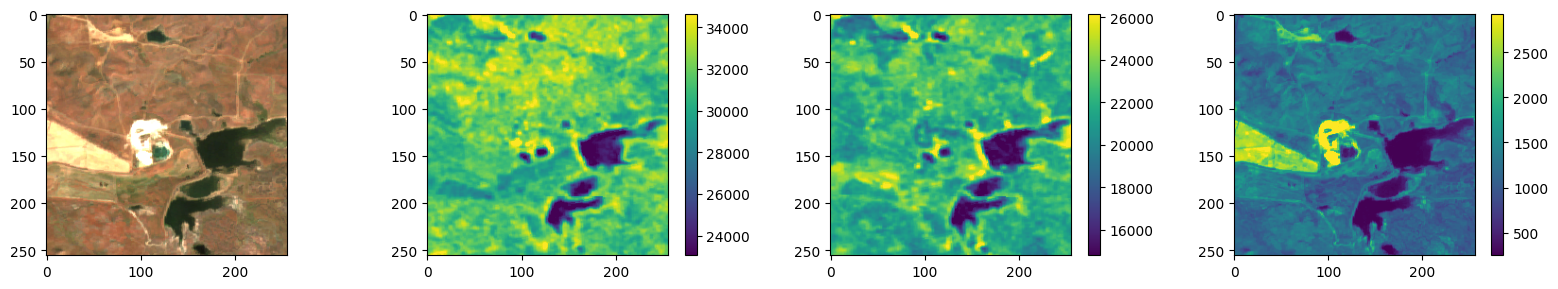

In [101]:
c.show()